In [1]:
!nvidia-smi

Thu Apr 22 13:08:27 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!cat /proc/uptime | awk '{print $1 /60 /60 /24 "days (" $1 "sec)"}'

0.00561539days (485.17sec)


In [3]:
!git clone https://github.com/yours-schnee/custom_ImageNet.git

Cloning into 'custom_ImageNet'...
remote: Enumerating objects: 57, done.
remote: Counting objects: 100% (57/57), done.
remote: Compressing objects: 100% (50/50), done.
remote: Total 57 (delta 19), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (57/57), done.


In [4]:
!pip install -e ./custom_ImageNet

ERROR: File "setup.py" not found. Directory cannot be installed in editable mode: /content/custom_ImageNet


In [5]:
import sys
sys.path.append('/content/custom_ImageNet')

import custom_ImageNet
from utils.ImageNetDataset import make_path_list
from utils.ImageNetDataset import str_convert
from utils.ImageNetDataset import ImageNetDataset

In [6]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.nn import init
from torch.optim import lr_scheduler
from torch import optim

In [7]:
import glob
import os
import time
import shutil
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.autonotebook import tqdm

from torchvision import transforms
from torchvision import models
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid

from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.metrics import classification_report
import statistics
import itertools
np.set_printoptions(threshold=np.inf)
#from PIL import Image  
import PIL
import PIL.Image
from PIL import ImageFile

#import copy
from copy import deepcopy
from torchsummary import summary
import torch.utils.data as data
import datetime

!pip install tensorboardX
import tensorboardX as tbx
from tensorboardX import SummaryWriter


     |████████████████████████████████| 122kB 9.1MB/s 


In [8]:
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
!cp "drive/My Drive/ImageNet/retina_10random_ImagenetTrain.zip" /content/
!cp "drive/My Drive/ImageNet/retina_original_ImagenetTest.zip" /content/

In [11]:
!apt-get install p7zip-full

Reading package lists... Done
Building dependency tree       
Reading state information... Done
p7zip-full is already the newest version (16.02+dfsg-6).
0 upgraded, 0 newly installed, 0 to remove and 31 not upgraded.


In [12]:
!7z x retina_10random_ImagenetTrain.zip
!mv "content/retina_ImagenetTrain" ../content/


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 2888291374 bytes (2755 MiB)

Extracting archive: retina_10random_ImagenetTrain.zip
  2% 4096 Open              --
Path = retina_10random_ImagenetTrain.zip
Type = zip
Physical Size = 2888291374
64-bit = +

  0%      0% 561 - content/retina_ImagenetTrain/pineapple/pineapple_6736.jpg                                                                      0% 943          0% 1246 - content/retina_ImagenetTrain/pineapple/pineapple_4504.jpg                                  

In [13]:
!7z x retina_original_ImagenetTest.zip
!mv "content/retina_ImagenetTest" ../content/


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 34489251 bytes (33 MiB)

Extracting archive: retina_original_ImagenetTest.zip
--
Path = retina_original_ImagenetTest.zip
Type = zip
Physical Size = 34489251

  0%     38% 795 - content/retina_ImagenetTest/elephant/elephant_030.jpg                                                                 74% 1508 - content/retina_ImagenetTest/zebra/zebra_026.jpg                                                           Everything is Ok

Folders: 21
Files: 2000
Size:       34552

In [14]:
import shutil

directory = 'content'

try:
    shutil.rmtree(directory)
except FileNotFoundError:
    pass

In [15]:
rootpathTrain ='retina_ImagenetTrain/'
rootpathTest ='retina_ImagenetTest/'

# Get folder name
train_img_list = make_path_list(rootpathTrain)
test_img_list = make_path_list(rootpathTest)

In [16]:
simple_transform = transforms.Compose([transforms.Resize((224,224),interpolation=3),
                                       transforms.ToTensor()])

train_dataset = ImageNetDataset(train_img_list, phase="train", transform=simple_transform)

test_dataset = ImageNetDataset(test_img_list, phase="test",
                          transform=simple_transform)


/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:258: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


In [17]:
use_cuda = torch.cuda.is_available()
torch.manual_seed(1)
np.random.seed(6)
device = torch.device("cuda" if use_cuda else "cpu")
#classes_list = train_dataset.get_label_relation()
classes_list = test_dataset.get_label_relation()

batch_size = 32

In [18]:
# training data split to train and val
validation_split = .2

dataset_size = len(train_dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))

np.random.shuffle(indices)
train_idx, valid_idx = indices[split:], indices[:split]

# Creating PT data samplers
train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
val_sampler = torch.utils.data.SubsetRandomSampler(valid_idx)

In [19]:
# dataloder
trainloader = data.DataLoader(
    train_dataset, batch_size=batch_size, sampler=train_sampler, num_workers=2)

valloader = data.DataLoader(
    train_dataset, batch_size=batch_size, sampler=val_sampler, num_workers=2)

#trainloader = data.DataLoader(
#    train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

testloader = data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

dataloaders_dict = {"train": trainloader, "val": valloader}

In [20]:
index_dict = {"train": train_idx, "val": valid_idx}
len(index_dict["train"])

141568

In [21]:
"""cnt = 0
for epoch in range(2):
    for images, labels in tqdm(testloader):
        cnt += 1
        if (cnt%10)
        print()"""

'cnt = 0\nfor epoch in range(2):\n    for images, labels in tqdm(testloader):\n        cnt += 1\n        if (cnt%10)\n        print()'

--------------------
(224, 224, 3)


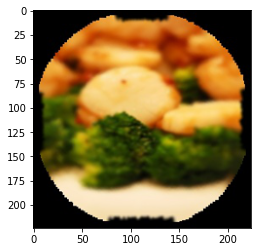

In [22]:
index = 2
imges, label = test_dataset.__getitem__(index)

img_val = imges
img_val = img_val.numpy().transpose((1, 2, 0))
print("--------------------")
print(img_val.shape)
plt.imshow(img_val)
plt.show()


In [23]:
#code adapted from https://scikit-learn.org/0.18/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion(cm, classes, name, normalize=False, title='Confusion matrix',cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    #print(cm)
    filename= name + "_confusion.png"
    path = F"/content/drive/My Drive/Colab Notebooks/Graphs/"
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, "{:0.0f}".format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig(path+filename)


In [24]:
def plot_graph(training_losses,val_losses,epochs,string,name):
    
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel(string)

    filename = name + "_" + string + "_.png" 
    path = F"/content/drive/My Drive/Colab Notebooks/Graphs/{filename}"
    plt.title(string + 'per epoch - ' + "Simple classifier")
    
    plt.plot(range(epochs),training_losses,label="Training " + string)
    plt.plot(range(epochs),val_losses,label="Validation " + string)
    plt.legend()
    plt.savefig(path+filename)
    print(path+filename)

In [25]:
# This function will test mask image generation, not the difference between original and generated images
  
def test_model(model, criterion, name):

    model.eval()
    test_epoch_loss = 0
    test_correct = 0
    best_accuracy = 0
    class_correct = list(0 for i in range(N_CLASSES))
    class_total = list(0 for i in range(N_CLASSES))
    mean_accuracies = list(0 for i in range(n_iterations))
    predlist=torch.zeros(0,dtype=torch.long, device='cpu')
    labelslist=torch.zeros(0,dtype=torch.long, device='cpu')

    with torch.no_grad():
        accuracies = [[] for i in range(n_iterations)]
        #for index,(images, anno, labels) in enumerate(testloader):
        for index,(images, labels) in enumerate(testloader):
            images, labels = images.cuda(), labels.cuda()

            predicted = model(images)
            loss = criterion(predicted,labels)

            test_epoch_loss += loss.item()

            best_predicted = predicted
            _, predicted_l = torch.max(best_predicted.data, 1)
            test_correct += (predicted_l == labels).sum().item()
            c = (predicted_l == labels).squeeze()

            predlist=torch.cat([predlist,predicted_l.view(-1).cpu()])
            labelslist=torch.cat([labelslist,labels.view(-1).cpu()])

            for i in range(labels.size(0)):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1

    test_epoch_loss /= len(testloader)
    print('\nTest loss: {:.4f} \nTesting Accuracy: {}/{} ({:.2f}%)'.format(
          test_epoch_loss, test_correct, len(testloader.dataset),
          100. * test_correct / len(testloader.dataset)))
    for i in range(N_CLASSES):
        print("{} Class Accuracy: {}/{} ({:.2f}%)".format(classes_list[i],class_correct[i],class_total[i],100*class_correct[i]/class_total[i]))

    precision = precision_score(predlist.numpy(), labelslist.numpy(), average='macro')
    recall = recall_score(predlist.numpy(), labelslist.numpy(), average='macro')
    accuracy = accuracy_score(predlist.numpy(), labelslist.numpy())
    f1 = fbeta_score(predlist.numpy(), labelslist.numpy(), 1, average='macro') #1 means f_1 measure
    print("Classifier has Acc=%0.3f P=%0.3f R=%0.3f F1=%0.3f" % (accuracy,precision,recall,f1))
    conf_matrix=confusion_matrix(labelslist.numpy(), predlist.numpy())
    plt.figure(figsize=(8, 8))
    plot_confusion(conf_matrix, classes_list, name, 'Confusion matrix')
    print(classification_report(labelslist.numpy(), predlist.numpy(),target_names=classes_list))

    return mean_accuracies

### Loss function

In [26]:
# Loss fuc setting
criterion = nn.CrossEntropyLoss()

### Training & Test for model

In [28]:
def train_model(model, dataloaders_dict, criterion, optimizer, num_epochs, name, folder_name, debug_mode=False):
    
    log_path = F"/content/drive/My Drive/Colab Notebooks/Log/"
    now = datetime.datetime.now()
    folder = F"{name}"+now.strftime('%Y%m%d_%H%M%S')

    writer = tbx.SummaryWriter(log_path+folder)

    global best_accuracy;
    global training_losses; global val_losses;
    global train_accuracies; global val_accuracies;
    global epochs;
    global stats;
    train_loss=0; val_loss=0; train_acc=0; val_acc=0; 
    for epoch in range(epochs,num_epochs):
        epoch = epoch + 1
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('-------------')

        # loop for training and validation every epoch
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()   # training mode
            else:
                model.eval()    # validation mode

            epoch_loss = 0.0    # epoch loss
            epoch_acc = 0       # epoch correct

            #for images, anno, labels in tqdm(dataloaders_dict[phase]):
            for images, labels in tqdm(dataloaders_dict[phase]):
                #images, anno, labels = images.cuda(), anno.cuda(), labels.cuda()
                images, labels = images.cuda(), labels.cuda()
      
                # initialize optimizer
                optimizer.zero_grad()

                # feedforward calc
                with torch.set_grad_enabled(phase == 'train'):
                    predicted = model(images)
                    loss = criterion(predicted, labels)       # loss calc
                    preds = predicted.max(1,keepdim=True)[1]  # label preds

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                    # calc of iter results
                    epoch_loss += loss.item()
                    epoch_acc += preds.eq(labels.view_as(preds)).sum().item()

            #print(epoch_acc)
            epoch_loss = epoch_loss / len(index_dict[phase])
            epoch_acc = epoch_acc / len(index_dict[phase]) *100.
            
            # stats data save
            if phase == 'train':
                training_losses.append(epoch_loss)
                train_accuracies.append(epoch_acc)
                train_loss=epoch_loss; train_acc=epoch_acc;
            else:
                val_losses.append(epoch_loss)
                val_accuracies.append(epoch_acc)
                val_loss=epoch_loss; val_acc=epoch_acc;

                # best model save
                if (epoch_acc > best_accuracy) and debug_mode==False:
                    best_accuracy = epoch_acc
                    best_model = deepcopy(model)
                    
                    total_name = name+".tar"
                    path = F"/content/drive/My Drive/Colab Notebooks/Retina_image/{folder_name}/{total_name}"
                    torch.save({"best_model":model.state_dict(),
                                "best_acc":best_accuracy
                                },path)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

        if (epoch%4==0)or(epoch%10==0):
            # Colab's disconnection timing while saving data might cause the broken save data against our hope.
            # So, results every epochs will be saved every epochs.
            
            total_name = name+"_epoch"+str(epoch)+".tar"

            path = F"/content/drive/My Drive/Colab Notebooks/Retina_image/{folder_name}/{total_name}"
            torch.save({
                "epoch":epoch,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "train_loss":training_losses,
                "val_loss":val_losses,
                "train_acc":train_accuracies,
                "val_acc":val_accuracies
                }, path)
            
        print('-------------')
        writer.add_scalars('/loss', {'train_loss': train_loss,
                                     'val_loss': val_loss
                                    }, epoch)
      
        writer.add_scalars('/acc', {'train_acc': train_acc,
                                    'val_acc': val_acc
                                    }, epoch)

    print("Lowest training loss", min(training_losses))
    print("Lowest validation loss", min(val_losses))
    print("Highest training accuracy",max(train_accuracies))
    print("Highest validation accuracy",max(val_accuracies))
    print('-------------')

    stats.append(training_losses)
    stats.append(train_accuracies)
    stats.append(val_losses)
    stats.append(val_accuracies)

    return best_model, stats

### VGG16 fine tuning

In [29]:
# Load pre-trained VGG-16
use_pretrained = True
net = models.vgg16(pretrained=use_pretrained)

N_CLASSES = 20

# Replacement last layer output for 20 classes
net.classifier[6] = nn.Linear(in_features=4096, out_features=N_CLASSES)

net.cuda()

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [30]:
"""# Store parameters through transfer learning, which are re-trained
params_to_update_1 = []
params_to_update_2 = []
params_to_update_3 = []

# Re-trained params
update_param_names_1 = ["features"]
update_param_names_2 = ["classifier.0.weight",
                        "classifier.0.bias", "classifier.3.weight", "classifier.3.bias"]
update_param_names_3 = ["classifier.6.weight", "classifier.6.bias"]

# Non re-trained params keep their grads
for name, param in net.named_parameters():
    if update_param_names_1[0] in name:
        param.requires_grad = True
        params_to_update_1.append(param)
        print("params_to_update_1 stores：", name)

    elif name in update_param_names_2:
        param.requires_grad = True
        params_to_update_2.append(param)
        print("params_to_update_2 stores：", name)

    elif name in update_param_names_3:
        param.requires_grad = True
        params_to_update_3.append(param)
        print("params_to_update_3 stores：", name)

    else:
        param.requires_grad = False
        print("Freazed：", name)"""

'# Store parameters through transfer learning, which are re-trained\nparams_to_update_1 = []\nparams_to_update_2 = []\nparams_to_update_3 = []\n\n# Re-trained params\nupdate_param_names_1 = ["features"]\nupdate_param_names_2 = ["classifier.0.weight",\n                        "classifier.0.bias", "classifier.3.weight", "classifier.3.bias"]\nupdate_param_names_3 = ["classifier.6.weight", "classifier.6.bias"]\n\n# Non re-trained params keep their grads\nfor name, param in net.named_parameters():\n    if update_param_names_1[0] in name:\n        param.requires_grad = True\n        params_to_update_1.append(param)\n        print("params_to_update_1 stores：", name)\n\n    elif name in update_param_names_2:\n        param.requires_grad = True\n        params_to_update_2.append(param)\n        print("params_to_update_2 stores：", name)\n\n    elif name in update_param_names_3:\n        param.requires_grad = True\n        params_to_update_3.append(param)\n        print("params_to_update_3 stores

In [31]:
"""vgg_optimizer2 = optim.SGD([
    {'params': params_to_update_1, 'lr': 1e-4},
    {'params': params_to_update_2, 'lr': 5e-4},
    {'params': params_to_update_3, 'lr': 1e-3}
], momentum=0.9)"""

"vgg_optimizer2 = optim.SGD([\n    {'params': params_to_update_1, 'lr': 1e-4},\n    {'params': params_to_update_2, 'lr': 5e-4},\n    {'params': params_to_update_3, 'lr': 1e-3}\n], momentum=0.9)"

In [32]:
# Optimization setting
vgg_optimizer2 = optim.SGD(net.parameters(), lr=0.0008, momentum=0.9)

### CONST data

In [33]:
# for FC layer's input size computation
img_shapes = [224, 224]

DEBUG = False
if DEBUG:
    NUM_EPOCS = 14
else:
    NUM_EPOCS = 40

n_iterations = 50
N_CLASSES = 20
FC_H = img_shapes[0]//2**4 # 4 is max plling layer num
FC_W = img_shapes[1]//2**4

In [34]:
LOAD_STATE = False
EPOCH = 16             # This values need to check the latest tar ffile name with epoch.
name = "05_VGG_fine_simpoptim"
folder_name = "VGG_fine"

if LOAD_STATE:
    stats=[];
    
    PATH1 =  F"/content/drive/My Drive/Colab Notebooks/Retina_image/{folder_name}/{name}.tar"

    checkpoint = torch.load(PATH1)
    best_model = net
    best_model.load_state_dict( checkpoint["best_model"] )
    best_accuracy = 0#checkpoint["best_acc"]

    # Colab's disconnection timing while saving data might cause the broken save data against our hope.
    # So, results every epochs will be saved every epochs.
    total_name = name+"_epoch"+str(EPOCH)+".tar"
    PATH2 =  F"/content/drive/My Drive/Colab Notebooks/Retina_image/{folder_name}/{total_name}"

    checkpoint = torch.load(PATH2)
    epochs = checkpoint["epoch"]
    net.load_state_dict( checkpoint["model_state_dict"] )
    vgg_optimizer2.load_state_dict( checkpoint["optimizer_state_dict"] )
    training_losses = checkpoint["train_loss"]; val_losses = checkpoint["val_loss"];
    train_accuracies = checkpoint["train_acc"]; val_accuracies = checkpoint["val_acc"];
    stats.append(training_losses)
    stats.append(train_accuracies)
    stats.append(val_losses)
    stats.append(val_accuracies)

else:
    # start point
    best_model=net;
    best_accuracy = 0;
    training_losses = []; val_losses = [];
    train_accuracies = []; val_accuracies = [];
    stats=[];
    epochs=0;


In [35]:
best_vgg2, stats_vgg2 = train_model(net, dataloaders_dict, criterion, vgg_optimizer2, NUM_EPOCS, name, folder_name, DEBUG)

Epoch 1/40
-------------



train Loss: 0.0247 Acc: 74.6447



val Loss: 0.0159 Acc: 83.5274
-------------
Epoch 2/40
-------------



train Loss: 0.0140 Acc: 85.4925



val Loss: 0.0129 Acc: 86.8473
-------------
Epoch 3/40
-------------



train Loss: 0.0094 Acc: 90.1355



val Loss: 0.0112 Acc: 88.5285
-------------
Epoch 4/40
-------------



train Loss: 0.0064 Acc: 93.3438



val Loss: 0.0086 Acc: 91.2014
-------------
Epoch 5/40
-------------



train Loss: 0.0045 Acc: 95.2228



val Loss: 0.0078 Acc: 92.1084
-------------
Epoch 6/40
-------------



train Loss: 0.0033 Acc: 96.4801



val Loss: 0.0075 Acc: 92.6622
-------------
Epoch 7/40
-------------



train Loss: 0.0024 Acc: 97.4295



val Loss: 0.0079 Acc: 93.0182
-------------
Epoch 8/40
-------------



train Loss: 0.0020 Acc: 97.9275



val Loss: 0.0081 Acc: 92.5746
-------------
Epoch 9/40
-------------



train Loss: 0.0015 Acc: 98.4036



val Loss: 0.0092 Acc: 92.2751
-------------
Epoch 10/40
-------------



train Loss: 0.0014 Acc: 98.5851



val Loss: 0.0079 Acc: 93.3290
-------------
Epoch 11/40
-------------



train Loss: 0.0011 Acc: 98.8733



val Loss: 0.0079 Acc: 93.6426
-------------
Epoch 12/40
-------------



train Loss: 0.0009 Acc: 99.0739



val Loss: 0.0069 Acc: 94.1427
-------------
Epoch 13/40
-------------



train Loss: 0.0009 Acc: 99.0994



val Loss: 0.0082 Acc: 93.6455
-------------
Epoch 14/40
-------------



train Loss: 0.0007 Acc: 99.2491



val Loss: 0.0070 Acc: 94.6542
-------------
Epoch 15/40
-------------



train Loss: 0.0006 Acc: 99.3593



val Loss: 0.0074 Acc: 94.3010
-------------
Epoch 16/40
-------------



train Loss: 0.0005 Acc: 99.4526



val Loss: 0.0080 Acc: 94.0297
-------------
Epoch 17/40
-------------



train Loss: 0.0005 Acc: 99.4949



val Loss: 0.0070 Acc: 94.9791
-------------
Epoch 18/40
-------------



train Loss: 0.0004 Acc: 99.5790



val Loss: 0.0083 Acc: 93.8743
-------------
Epoch 19/40
-------------



train Loss: 0.0004 Acc: 99.5924



val Loss: 0.0068 Acc: 95.0300
-------------
Epoch 20/40
-------------



train Loss: 0.0004 Acc: 99.5705



val Loss: 0.0072 Acc: 94.7107
-------------
Epoch 21/40
-------------



train Loss: 0.0004 Acc: 99.5797



val Loss: 0.0063 Acc: 95.3182
-------------
Epoch 22/40
-------------



train Loss: 0.0003 Acc: 99.7090



val Loss: 0.0070 Acc: 94.6768
-------------
Epoch 23/40
-------------



train Loss: 0.0003 Acc: 99.7245



val Loss: 0.0088 Acc: 93.6681
-------------
Epoch 24/40
-------------



train Loss: 0.0003 Acc: 99.7273



val Loss: 0.0069 Acc: 94.9960
-------------
Epoch 25/40
-------------



train Loss: 0.0003 Acc: 99.7591



val Loss: 0.0070 Acc: 95.3521
-------------
Epoch 26/40
-------------



train Loss: 0.0002 Acc: 99.7803



val Loss: 0.0074 Acc: 94.9254
-------------
Epoch 27/40
-------------



train Loss: 0.0003 Acc: 99.7083



val Loss: 0.0075 Acc: 94.9480
-------------
Epoch 28/40
-------------



train Loss: 0.0002 Acc: 99.7937



val Loss: 0.0076 Acc: 94.8632
-------------
Epoch 29/40
-------------



train Loss: 0.0003 Acc: 99.6885



val Loss: 0.0077 Acc: 95.1599
-------------
Epoch 30/40
-------------



train Loss: 0.0003 Acc: 99.7344



val Loss: 0.0077 Acc: 94.5976
-------------
Epoch 31/40
-------------



train Loss: 0.0002 Acc: 99.7697



val Loss: 0.0063 Acc: 95.8352
-------------
Epoch 32/40
-------------



train Loss: 0.0001 Acc: 99.8870



val Loss: 0.0084 Acc: 95.0384
-------------
Epoch 33/40
-------------



train Loss: 0.0002 Acc: 99.7846



val Loss: 0.0078 Acc: 94.6203
-------------
Epoch 34/40
-------------



train Loss: 0.0002 Acc: 99.8192



val Loss: 0.0064 Acc: 95.8493
-------------
Epoch 35/40
-------------



train Loss: 0.0001 Acc: 99.8955



val Loss: 0.0077 Acc: 95.3690
-------------
Epoch 36/40
-------------



train Loss: 0.0002 Acc: 99.8213



val Loss: 0.0073 Acc: 94.9028
-------------
Epoch 37/40
-------------



train Loss: 0.0002 Acc: 99.8015



val Loss: 0.0078 Acc: 94.8378
-------------
Epoch 38/40
-------------



train Loss: 0.0001 Acc: 99.8580



val Loss: 0.0064 Acc: 95.8126
-------------
Epoch 39/40
-------------



train Loss: 0.0001 Acc: 99.8976



val Loss: 0.0072 Acc: 95.5188
-------------
Epoch 40/40
-------------



train Loss: 0.0001 Acc: 99.8940



val Loss: 0.0076 Acc: 95.5696
-------------
Lowest training loss 0.00010050833784495914
Lowest validation loss 0.006284753750199452
Highest training accuracy 99.89757572332731
Highest validation accuracy 95.8493444846293
-------------


/content/drive/My Drive/Colab Notebooks/Graphs/05_VGG_fine_simpoptim_Loss _.png05_VGG_fine_simpoptim_Loss _.png
/content/drive/My Drive/Colab Notebooks/Graphs/05_VGG_fine_simpoptim_Accuracy _.png05_VGG_fine_simpoptim_Accuracy _.png


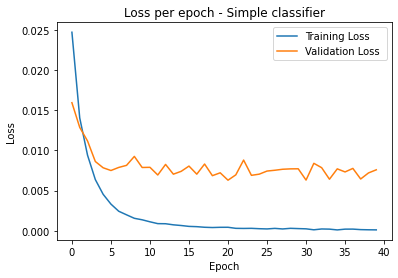

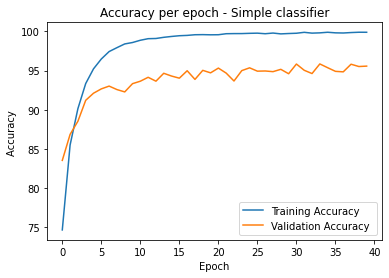

In [36]:
plt.rcParams["figure.figsize"] = (6,4)
plot_graph(stats_vgg2[0],stats_vgg2[2],NUM_EPOCS,"Loss ",name)
plot_graph(stats_vgg2[1],stats_vgg2[3],NUM_EPOCS,"Accuracy ",name)


Test loss: 1.1109 
Testing Accuracy: 1679/2000 (83.95%)
apple Class Accuracy: 70/100 (70.00%)
banana Class Accuracy: 86/100 (86.00%)
bear Class Accuracy: 89/100 (89.00%)
bell_pepper Class Accuracy: 82/100 (82.00%)
bird Class Accuracy: 82/100 (82.00%)
broccoli Class Accuracy: 80/100 (80.00%)
cat Class Accuracy: 80/100 (80.00%)
cauliflower Class Accuracy: 85/100 (85.00%)
cow Class Accuracy: 93/100 (93.00%)
dog Class Accuracy: 75/100 (75.00%)
elephant Class Accuracy: 93/100 (93.00%)
fox Class Accuracy: 90/100 (90.00%)
goat Class Accuracy: 80/100 (80.00%)
horse Class Accuracy: 78/100 (78.00%)
mashed_potato Class Accuracy: 90/100 (90.00%)
orange Class Accuracy: 83/100 (83.00%)
pineapple Class Accuracy: 82/100 (82.00%)
pomegranate Class Accuracy: 83/100 (83.00%)
tomato Class Accuracy: 83/100 (83.00%)
zebra Class Accuracy: 95/100 (95.00%)
Classifier has Acc=0.840 P=0.839 R=0.843 F1=0.840
               precision    recall  f1-score   support

        apple       0.84      0.70      0.77     

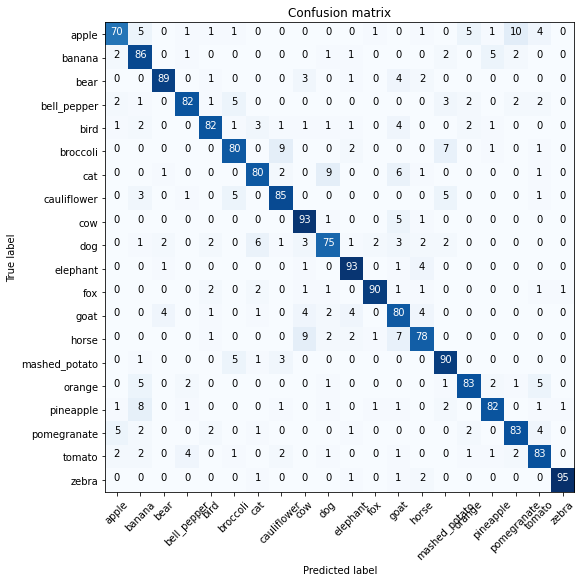

In [37]:
result = test_model(best_vgg2,criterion, name)

### Learning rate = 0.008 results

In [ ]:
best_vgg2, stats_vgg2 = train_model(net, dataloaders_dict, criterion, vgg_optimizer2, NUM_EPOCS, name, folder_name, DEBUG)

Epoch 17/40
-------------



train Loss: 0.0066 Acc: 93.4964



val Loss: 0.0178 Acc: 83.5867
-------------
Epoch 18/40
-------------



train Loss: 0.0071 Acc: 93.0902



val Loss: 0.0161 Acc: 84.9599
-------------
Epoch 19/40
-------------



train Loss: 0.0080 Acc: 92.3097



val Loss: 0.0167 Acc: 84.2168
-------------
Epoch 20/40
-------------



train Loss: 0.0089 Acc: 91.4260



val Loss: 0.0180 Acc: 83.1883
-------------
Epoch 21/40
-------------



train Loss: 0.0100 Acc: 90.4491



val Loss: 0.0204 Acc: 81.1596
-------------
Epoch 22/40
-------------



train Loss: 0.0124 Acc: 88.1117



val Loss: 0.0216 Acc: 80.0407
-------------
Epoch 23/40
-------------



train Loss: 0.0166 Acc: 84.2938



val Loss: 0.0266 Acc: 75.1921
-------------
Epoch 24/40
-------------



train Loss: 0.0220 Acc: 79.2241



val Loss: 0.0287 Acc: 73.4545
-------------
Epoch 25/40
-------------



train Loss: 0.0312 Acc: 70.4566



val Loss: 0.0386 Acc: 64.1049
-------------
Epoch 26/40
-------------



train Loss: 0.0424 Acc: 59.6251



val Loss: 0.0508 Acc: 53.1193
-------------
Epoch 27/40
-------------



train Loss: 0.0589 Acc: 43.0246



val Loss: 0.0655 Acc: 37.8362
-------------
Epoch 28/40
-------------



train Loss: 0.0831 Acc: 17.9850



val Loss: 0.0932 Acc: 7.5158
-------------
Epoch 29/40
-------------



train Loss: 0.0932 Acc: 7.3322



val Loss: 0.0932 Acc: 7.5158
-------------
Epoch 30/40
-------------



train Loss: 0.0932 Acc: 7.3399



val Loss: 0.0932 Acc: 7.5158
-------------
Epoch 31/40
-------------



train Loss: 0.0932 Acc: 7.3258



val Loss: 0.0932 Acc: 7.5158
-------------
Epoch 32/40
-------------



train Loss: 0.0932 Acc: 7.3399



val Loss: 0.0932 Acc: 7.5158
-------------
Epoch 33/40
-------------



train Loss: 0.0932 Acc: 7.3272



val Loss: 0.0932 Acc: 7.5158
-------------
Epoch 34/40
-------------



train Loss: 0.0932 Acc: 7.3385



val Loss: 0.0932 Acc: 7.5158
-------------
Epoch 35/40
-------------



train Loss: 0.0932 Acc: 7.3364



val Loss: 0.0932 Acc: 7.5158
-------------
Epoch 36/40
-------------



train Loss: 0.0932 Acc: 7.3237



val Loss: 0.0932 Acc: 7.5158
-------------
Epoch 37/40
-------------



train Loss: 0.0932 Acc: 7.3385



val Loss: 0.0932 Acc: 7.5158
-------------
Epoch 38/40
-------------



train Loss: 0.0932 Acc: 7.3428



val Loss: 0.0932 Acc: 7.5158
-------------
Epoch 39/40
-------------



train Loss: 0.0932 Acc: 7.3385



val Loss: 0.0932 Acc: 7.5158
-------------
Epoch 40/40
-------------



train Loss: 0.0932 Acc: 7.3286



val Loss: 0.0932 Acc: 7.5158
-------------
Lowest training loss 0.006356738559501682
Lowest validation loss 0.013137699371569236
Highest training accuracy 93.68218806509945
Highest validation accuracy 87.08465189873418
-------------


/content/drive/My Drive/Colab Notebooks/Graphs/05_VGG_fine_simpoptim_Loss _.png05_VGG_fine_simpoptim_Loss _.png
/content/drive/My Drive/Colab Notebooks/Graphs/05_VGG_fine_simpoptim_Accuracy _.png05_VGG_fine_simpoptim_Accuracy _.png


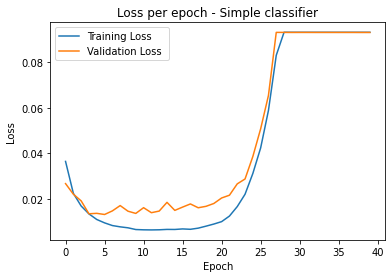

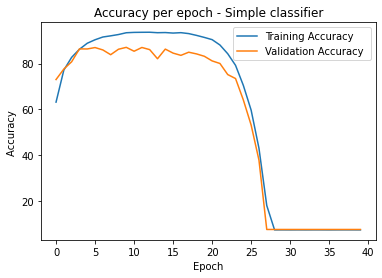

In [ ]:
plt.rcParams["figure.figsize"] = (6,4)
plot_graph(stats_vgg2[0],stats_vgg2[2],NUM_EPOCS,"Loss ",name)
plot_graph(stats_vgg2[1],stats_vgg2[3],NUM_EPOCS,"Accuracy ",name)


Test loss: 1.1807 
Testing Accuracy: 1388/2000 (69.40%)
apple Class Accuracy: 62/100 (62.00%)
banana Class Accuracy: 79/100 (79.00%)
bear Class Accuracy: 81/100 (81.00%)
bell_pepper Class Accuracy: 60/100 (60.00%)
bird Class Accuracy: 60/100 (60.00%)
broccoli Class Accuracy: 81/100 (81.00%)
cat Class Accuracy: 63/100 (63.00%)
cauliflower Class Accuracy: 49/100 (49.00%)
cow Class Accuracy: 84/100 (84.00%)
dog Class Accuracy: 57/100 (57.00%)
elephant Class Accuracy: 87/100 (87.00%)
fox Class Accuracy: 73/100 (73.00%)
goat Class Accuracy: 56/100 (56.00%)
horse Class Accuracy: 66/100 (66.00%)
mashed_potato Class Accuracy: 67/100 (67.00%)
orange Class Accuracy: 60/100 (60.00%)
pineapple Class Accuracy: 69/100 (69.00%)
pomegranate Class Accuracy: 72/100 (72.00%)
tomato Class Accuracy: 72/100 (72.00%)
zebra Class Accuracy: 90/100 (90.00%)
Classifier has Acc=0.694 P=0.694 R=0.719 F1=0.696
               precision    recall  f1-score   support

        apple       0.53      0.62      0.57     

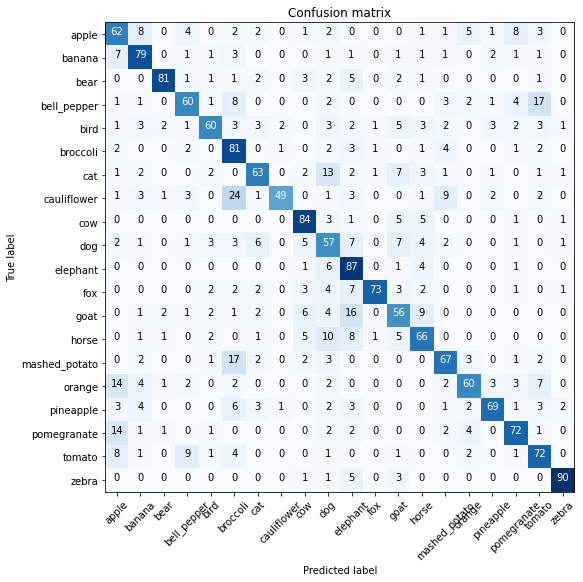

In [ ]:
result = test_model(best_vgg2,criterion, name)